In [1]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests
from io import BytesIO
import os
from dotenv import load_dotenv
from zipfile import ZipFile, BadZipFile
import json
import datetime
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from sklearn.datasets import fetch_openml
import seaborn as sns

pd.set_option('display.expand_frame_repr', False)

In [3]:
wiki_df = pd.read_csv('/home/noslen/alpaca-trading/data/WIKI_PRICES.csv')
print(wiki_df.info())
print(wiki_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15389314 entries, 0 to 15389313
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ticker       object 
 1   date         object 
 2   open         float64
 3   high         float64
 4   low          float64
 5   close        float64
 6   volume       float64
 7   ex-dividend  float64
 8   split_ratio  float64
 9   adj_open     float64
 10  adj_high     float64
 11  adj_low      float64
 12  adj_close    float64
 13  adj_volume   float64
dtypes: float64(12), object(2)
memory usage: 1.6+ GB
None
  ticker        date   open   high    low  close      volume  ex-dividend  split_ratio   adj_open   adj_high    adj_low  adj_close  adj_volume
0      A  1999-11-18  45.50  50.00  40.00  44.00  44739900.0          0.0          1.0  31.041951  34.112034  27.289627  30.018590  44739900.0
1      A  1999-11-19  42.94  43.00  39.81  40.38  10897100.0          0.0          1.0  29.295415  29.336350  27.160002  27.5

In [5]:
sharadar_indicators = pd.read_csv('/home/noslen/alpaca-trading/data/SHARADAR/SHARADAR_INDICATORS.csv')
print(sharadar_indicators.info())
print(sharadar_indicators.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   table         374 non-null    object
 1   indicator     374 non-null    object
 2   isfilter      374 non-null    object
 3   isprimarykey  374 non-null    object
 4   title         374 non-null    object
 5   description   368 non-null    object
 6   unittype      370 non-null    object
dtypes: object(7)
memory usage: 20.6+ KB
None
  table indicator isfilter isprimarykey                                       title                                        description  unittype
0   SF1   revenue        N            N                                    Revenues  [Income Statement] The amount of Revenue recog...  currency
1   SF1       cor        N            N                             Cost of Revenue  [Income Statement] The aggregate cost of goods...  currency
2   SF1      sgna        N           

## Create the datasets with updated data

In [3]:
tickers_data = pd.read_csv('/home/noslen/alpaca-trading/data/SHARADAR/SHARADAR_TICKERS.csv')

print(tickers_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58625 entries, 0 to 58624
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   table           58625 non-null  object 
 1   permaticker     58625 non-null  int64  
 2   ticker          46807 non-null  object 
 3   name            58625 non-null  object 
 4   exchange        46809 non-null  object 
 5   isdelisted      46809 non-null  object 
 6   category        58625 non-null  object 
 7   cusips          46693 non-null  object 
 8   siccode         39515 non-null  float64
 9   sicsector       39515 non-null  object 
 10  sicindustry     39515 non-null  object 
 11  famasector      0 non-null      float64
 12  famaindustry    38776 non-null  object 
 13  sector          38952 non-null  object 
 14  industry        38952 non-null  object 
 15  scalemarketcap  34185 non-null  object 
 16  scalerevenue    32184 non-null  object 
 17  relatedtickers  22251 non-null 

### Get Daily Metrics Data for current marketcap

In [6]:
# daily_data = nasdaqdatalink.get_table('SHARADAR_DAILY')
daily_data = pd.read_csv(
    "alpaca-trading/data/SHARADAR/SHARADAR_DAILY.csv",
    parse_dates=["date"],
    index_col=["date", "ticker"]
).sort_index()
# Find the maximum date
max_date = daily_data.index.get_level_values('date').max()

# Filter the DataFrame to include only the rows with the maximum date
daily_data = daily_data.loc[max_date]

# Reset the index to make 'ticker' a column
daily_data = daily_data.reset_index()

# Set the index to 'ticker' only
daily_data = daily_data.set_index('ticker')

print(daily_data.head())
print(daily_data.info())


       lastupdated       ev  evebit  evebitda  marketcap    pb      pe   ps
ticker                                                                     
A       2025-05-09  32382.0    20.4      17.5    30486.0   5.1    24.2  4.7
AA      2025-05-09   8156.7     5.6       3.9     6710.7   1.2     7.8  0.5
AACB    2025-05-09    293.0 -3447.1   -3447.1      293.4 -24.5 -3451.8  NaN
AACG    2025-05-09     30.7    -5.1     -11.6       30.9   2.8    -6.2  0.8
AACT    2025-05-09    708.4    27.3      27.3      704.4 -32.0    27.1  NaN
<class 'pandas.core.frame.DataFrame'>
Index: 5370 entries, A to nan
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lastupdated  5370 non-null   object 
 1   ev           5370 non-null   float64
 2   evebit       5360 non-null   float64
 3   evebitda     5358 non-null   float64
 4   marketcap    5370 non-null   float64
 5   pb           5369 non-null   float64
 6   pe           5361 non-null 

#### drop last index of dataframe:

In [7]:
daily_data.drop(daily_data.tail(1).index,inplace=True)
print(daily_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5369 entries, A to ZYXI
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lastupdated  5369 non-null   object 
 1   ev           5369 non-null   float64
 2   evebit       5359 non-null   float64
 3   evebitda     5357 non-null   float64
 4   marketcap    5369 non-null   float64
 5   pb           5368 non-null   float64
 6   pe           5360 non-null   float64
 7   ps           4836 non-null   float64
dtypes: float64(7), object(1)
memory usage: 377.5+ KB
None


In [2]:
sep_path = 'alpaca-trading/data/SHARADAR/SHARADAR_SEP.csv'
actions_path = 'alpaca-trading/data/SHARADAR/SHARADAR_ACTIONS.csv'

sep_data = pd.read_csv(
    sep_path,
    parse_dates=["date"],
    index_col=["date", "ticker"]
).sort_index()

actions_data = pd.read_csv(
    actions_path,
    parse_dates=["date"],
    index_col=["date", "ticker"]
).sort_index()

NameError: name 'pd' is not defined

In [10]:
# sep_data.drop(daily_data.tail(1).index,inplace=True)
print(sep_data.tail())

                    open    high    low   close    volume  closeadj  closeunadj lastupdated
date       ticker                                                                          
2025-05-09 ZWS     35.17  35.640  34.91  35.200  607309.0    35.200      35.200  2025-05-09
           ZYBT    10.44  10.710   9.53  10.310   76956.0    10.310      10.310  2025-05-09
           ZYME    11.38  12.185  11.00  11.305  657945.0    11.305      11.305  2025-05-09
           ZYXI     2.15   2.160   2.07   2.070   62781.0     2.070       2.070  2025-05-09
           NaN      4.28   4.400   4.00   4.190    4191.0     4.190       4.190  2025-05-09


In [12]:

# ticker,name,lastsale,marketcap,ipoyear,sector,industry

date = pd.Timestamp('2024-05-23') 

tickers_data["last_sale"] = tickers_data["ticker"].apply(
    lambda ticker: sep_data.loc[(date, ticker), 'close'] if (date, ticker) in sep_data.index else None
)
tickers_data['marketcap'] = tickers_data['ticker'].apply(
    lambda x: daily_data.loc[x, 'marketcap'] if x in daily_data.index else None
)
tickers_data["firstpricedate"] = pd.to_datetime(tickers_data["firstpricedate"], errors='coerce')
tickers_data["ipoyear"] = tickers_data["firstpricedate"].dt.year.astype(float)



stock_data = tickers_data[
    [
        "ticker",
        "name",
        "last_sale",
        "marketcap",
        "ipoyear",
        "sector",
        "industry"
    ]
]
stock_data = stock_data.dropna(subset=['marketcap'])


print(stock_data.info())


<class 'pandas.core.frame.DataFrame'>
Index: 10738 entries, 0 to 39455
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     10738 non-null  object 
 1   name       10738 non-null  object 
 2   last_sale  10102 non-null  float64
 3   marketcap  10738 non-null  float64
 4   ipoyear    10738 non-null  float64
 5   sector     10728 non-null  object 
 6   industry   10728 non-null  object 
dtypes: float64(3), object(4)
memory usage: 671.1+ KB
None


In [13]:
print(stock_data.head())


   ticker                       name  last_sale  marketcap  ipoyear              sector                       industry
0       A   AGILENT TECHNOLOGIES INC     150.55    30486.0   1999.0          Healthcare         Diagnostics & Research
1      AA                 ALCOA CORP      41.05     6710.7   2016.0     Basic Materials                       Aluminum
8    AACB  ARTIUS II ACQUISITION INC        NaN      293.4   2025.0         Industrials                Shell Companies
12   AACG      ATA CREATIVITY GLOBAL       0.88       30.9   2008.0  Consumer Defensive  Education & Training Services
15   AACT   ARES ACQUISITION CORP II      10.64      704.4   2023.0         Industrials                Shell Companies


In [15]:
stock_data.to_csv('alpaca-trading/data/STOCK_META_DATA.csv', index=False)


In [16]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10738 entries, 0 to 39455
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ticker     10738 non-null  object 
 1   name       10738 non-null  object 
 2   last_sale  10102 non-null  float64
 3   marketcap  10738 non-null  float64
 4   ipoyear    10738 non-null  float64
 5   sector     10728 non-null  object 
 6   industry   10728 non-null  object 
dtypes: float64(3), object(4)
memory usage: 671.1+ KB


## Create the new prices table

In [17]:
# OpenAdj = Open * CloseAdj / Close.

adj_factor = sep_data["closeadj"] / sep_data["close"]
# Calculate the adjusted values
sep_data["adj_open"] = sep_data["open"] * adj_factor
sep_data["adj_high"] = sep_data["high"] * adj_factor
sep_data["adj_low"] = sep_data["low"] * adj_factor
sep_data["adj_close"] = sep_data["closeadj"]

# Filter dividends and splits
dividends = actions_data.loc[actions_data["action"] == "dividend", "value"]
splits = actions_data.loc[actions_data["action"] == "split", "value"]

# Merge the dividends and splits into the SEP data
sep_data = sep_data.join(dividends.rename("ex-dividend"), how="left")
sep_data = sep_data.join(splits.rename("split_ratio"), how="left")

# Fill missing values for new columns
sep_data["ex-dividend"].fillna(0, inplace=True)
sep_data["split_ratio"].fillna(1, inplace=True) 
sep_data["adj_volume"] = sep_data["volume"]

# Reset index to manipulate date
sep_data.reset_index(inplace=True)

# Convert datetime to string
sep_data["date"] = sep_data["date"].astype(str)

# Select only required columns
final_df = sep_data[
    [
        "ticker",
        "date",
        "open",
        "high",
        "low",
        "close",
        "volume",
        "ex-dividend",
        "split_ratio",
        "adj_open",
        "adj_high",
        "adj_low",
        "adj_close",
        "adj_volume",
    ]
]
final_df.dropna(subset=["ticker"], inplace=True)
final_df.to_csv('data/SHARADAR_PRICES.csv', index=False)

# with pd.HDFStore(DATA_STORE) as store:
#     store.put('sharadar/equity/prices', final_df, format='table')
#     print("DataFrame stored successfully.")

# # Verifying what's stored
# with pd.HDFStore(DATA_STORE) as store:
#     if 'sharadar/equity/prices' in store:
#         df_stored = store['sharadar/equity/prices']
#         print(df_stored.columns)  # This will list all the columns stored

: 

: 

: 

In [13]:
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 17246022 entries, 0 to 17246492
Data columns (total 14 columns):
 #   Column       Dtype  
---  ------       -----  
 0   ticker       object 
 1   date         object 
 2   open         float64
 3   high         float64
 4   low          float64
 5   close        float64
 6   volume       float64
 7   ex-dividend  float64
 8   split_ratio  float64
 9   adj_open     float64
 10  adj_high     float64
 11  adj_low      float64
 12  adj_close    float64
 13  adj_volume   float64
dtypes: float64(12), object(2)
memory usage: 1.9+ GB
None


### Convert the new prices table to HDF5

In [14]:
prices = (pd.read_csv('data/SHARADAR_PRICES.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())
print(prices.info())
print(prices.head())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17246022 entries, (Timestamp('2014-01-02 00:00:00'), 'A') to (Timestamp('2024-05-24 00:00:00'), 'ZYXI')
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   open         float64
 1   high         float64
 2   low          float64
 3   close        float64
 4   volume       float64
 5   ex-dividend  float64
 6   split_ratio  float64
 7   adj_open     float64
 8   adj_high     float64
 9   adj_low      float64
 10  adj_close    float64
 11  adj_volume   float64
dtypes: float64(12)
memory usage: 1.6+ GB
None
                     open    high     low   close     volume  ex-dividend  split_ratio   adj_open   adj_high    adj_low  adj_close  adj_volume
date       ticker                                                                                                                             
2014-01-02 A       57.100  57.100  56.150  56.210  1916200.0          0.0          1.0  37.863161  37.863161  37.233

In [15]:
DATA_STORE = Path('data/assets.h5')

In [16]:

with pd.HDFStore(DATA_STORE) as store:
    store.put('sharadar/sep/prices', prices)
    # store.put('quandl/wiki/prices', prices)

In [17]:
print(prices.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17246022 entries, (Timestamp('2014-01-02 00:00:00'), 'A') to (Timestamp('2024-05-24 00:00:00'), 'ZYXI')
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   open         float64
 1   high         float64
 2   low          float64
 3   close        float64
 4   volume       float64
 5   ex-dividend  float64
 6   split_ratio  float64
 7   adj_open     float64
 8   adj_high     float64
 9   adj_low      float64
 10  adj_close    float64
 11  adj_volume   float64
dtypes: float64(12)
memory usage: 1.6+ GB
None


In [18]:
df = pd.read_csv('data/STOCK_META_DATA.csv')

with pd.HDFStore(DATA_STORE) as store:
    store.put('sharadar/sep/stocks', df.set_index('ticker'))
    print(store.info())
    #     store.put('quandl/wiki/stocks', df)

<class 'pandas.io.pytables.HDFStore'>
File path: data/assets.h5
/sharadar/sep/prices                               frame        (shape->[17246022,12])                                                                  
/sharadar/sep/stocks                               frame        (shape->[5494,6])                                                                       
/stooq/5/us/nasdaq/etfs/prices                     frame_table  (typ->appendable_multi,nrows->457963,ncols->9,indexers->[index],dc->[date_time,ticker]) 
/stooq/5/us/nasdaq/etfs/tickers                    frame_table  (typ->appendable,nrows->357,ncols->2,indexers->[index],dc->[])                          
/stooq/5/us/nasdaq/stocks/prices                   frame_table  (typ->appendable_multi,nrows->6317799,ncols->9,indexers->[index],dc->[date_time,ticker])
/stooq/5/us/nasdaq/stocks/tickers                  frame_table  (typ->appendable,nrows->4543,ncols->2,indexers->[index],dc->[])                         
/stooq/5/us/nyse/e

## Get Data

In [19]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [20]:
START = 2000
END = 2024

In [21]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['sharadar/sep/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['sharadar/sep/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]    

In [22]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2014-01-02 to 2024-05-24
Columns: 13263 entries, A to ZYXI
dtypes: float64(13263)
memory usage: 264.8 MB


In [23]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5494 entries, BOW to EVO
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5494 non-null   float64
 1   ipoyear    5494 non-null   float64
 2   sector     5490 non-null   object 
dtypes: float64(2), object(1)
memory usage: 171.7+ KB


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.


In [24]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

In [25]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5494 entries, BOW to EVO
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5494 non-null   float64
 1   ipoyear    5494 non-null   float64
 2   sector     5490 non-null   object 
dtypes: float64(2), object(1)
memory usage: 300.7+ KB


In [26]:
shared = prices.columns.intersection(stocks.index)

In [27]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5494 entries, A to ZYXI
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5494 non-null   float64
 1   ipoyear    5494 non-null   float64
 2   sector     5490 non-null   object 
dtypes: float64(2), object(1)
memory usage: 171.7+ KB


In [28]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2617 entries, 2014-01-02 to 2024-05-24
Columns: 5494 entries, A to ZYXI
dtypes: float64(5494)
memory usage: 109.7 MB


In [29]:
prices.head()

ticker,A,AA,AACG,AACI,AACT,AADI,AAGR,AAL,AAMC,AAME,...,ZTS,ZUMZ,ZUO,ZURA,ZVIA,ZVRA,ZVSA,ZWS,ZYME,ZYXI
date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,37.273,NaN,1.314,NaN,NaN,NaN,NaN,23.904,543.029,3.712,...,29.982,26.21,NaN,NaN,NaN,NaN,NaN,12.913,NaN,0.221
2014-01-03,37.743,NaN,1.310,NaN,NaN,NaN,NaN,25.016,543.935,3.795,...,29.695,26.15,NaN,NaN,NaN,NaN,NaN,13.070,NaN,0.221
2014-01-06,37.558,NaN,1.314,NaN,NaN,NaN,NaN,25.478,535.959,3.753,...,29.630,26.00,NaN,NaN,NaN,NaN,NaN,13.504,NaN,0.215
2014-01-07,38.095,NaN,1.337,NaN,NaN,NaN,NaN,25.360,548.529,3.767,...,29.741,26.60,NaN,NaN,NaN,NaN,NaN,13.566,NaN,0.228
2014-01-08,38.718,NaN,1.350,NaN,NaN,NaN,NaN,26.044,546.765,3.739,...,29.408,26.18,NaN,NaN,NaN,NaN,NaN,13.228,NaN,0.240


In [30]:
assert prices.shape[1] == stocks.shape[0]

In [31]:
monthly_prices = prices.resample('M').last()

In [32]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2014-01-31 to 2024-05-31
Freq: M
Columns: 5494 entries, A to ZYXI
dtypes: float64(5494)
memory usage: 5.2 MB


In [33]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 426571 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-05-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   426571 non-null  float64
 1   return_2m   426571 non-null  float64
 2   return_3m   426571 non-null  float64
 3   return_6m   426571 non-null  float64
 4   return_9m   426571 non-null  float64
 5   return_12m  426571 non-null  float64
dtypes: float64(6)
memory usage: 20.9+ MB


In [34]:
data.head()

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2015-01-31,-0.075164,-0.058785,-0.017760,-0.010937,-0.002936,-0.008083
AACG,2015-01-31,0.133039,0.128523,0.072906,0.001398,0.030021,0.025139
AAL,2015-01-31,-0.084831,0.005650,0.058797,0.040157,0.038634,0.032644
AAMC,2015-01-31,-0.419274,-0.332901,-0.290481,-0.200581,-0.182232,-0.142195
AAME,2015-01-31,-0.010008,0.017894,0.013667,-0.003287,0.015226,0.001297


In [35]:
min_obs = 1
nobs = data.groupby(level='ticker').size()
print(data.groupby(level='ticker').size())
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

ticker
A       113
AA       79
AACG    113
AACI     22
AACT      2
       ... 
ZVRA     98
ZVSA     18
ZWS     113
ZYME     74
ZYXI    113
Length: 5269, dtype: int64
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 426556 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-05-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   426556 non-null  float64
 1   return_2m   426556 non-null  float64
 2   return_3m   426556 non-null  float64
 3   return_6m   426556 non-null  float64
 4   return_9m   426556 non-null  float64
 5   return_12m  426556 non-null  float64
dtypes: float64(6)
memory usage: 20.9+ MB


In [36]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,426556.000000,426556.000000,426556.000000,426556.000000,426556.000000,426556.000000
mean,0.004428,-0.001275,-0.002974,-0.004818,-0.005798,-0.005890
std,0.151198,0.107020,0.087918,0.064248,0.054628,0.048587
min,-0.419274,-0.332901,-0.290481,-0.227340,-0.198156,-0.179183
25%,-0.070637,-0.051477,-0.042767,-0.032134,-0.028084,-0.024717
50%,0.000706,0.000946,0.001774,0.001447,0.000993,0.000838
75%,0.068927,0.048232,0.040011,0.028254,0.022997,0.020259
max,0.592265,0.368847,0.282090,0.179591,0.140659,0.118662


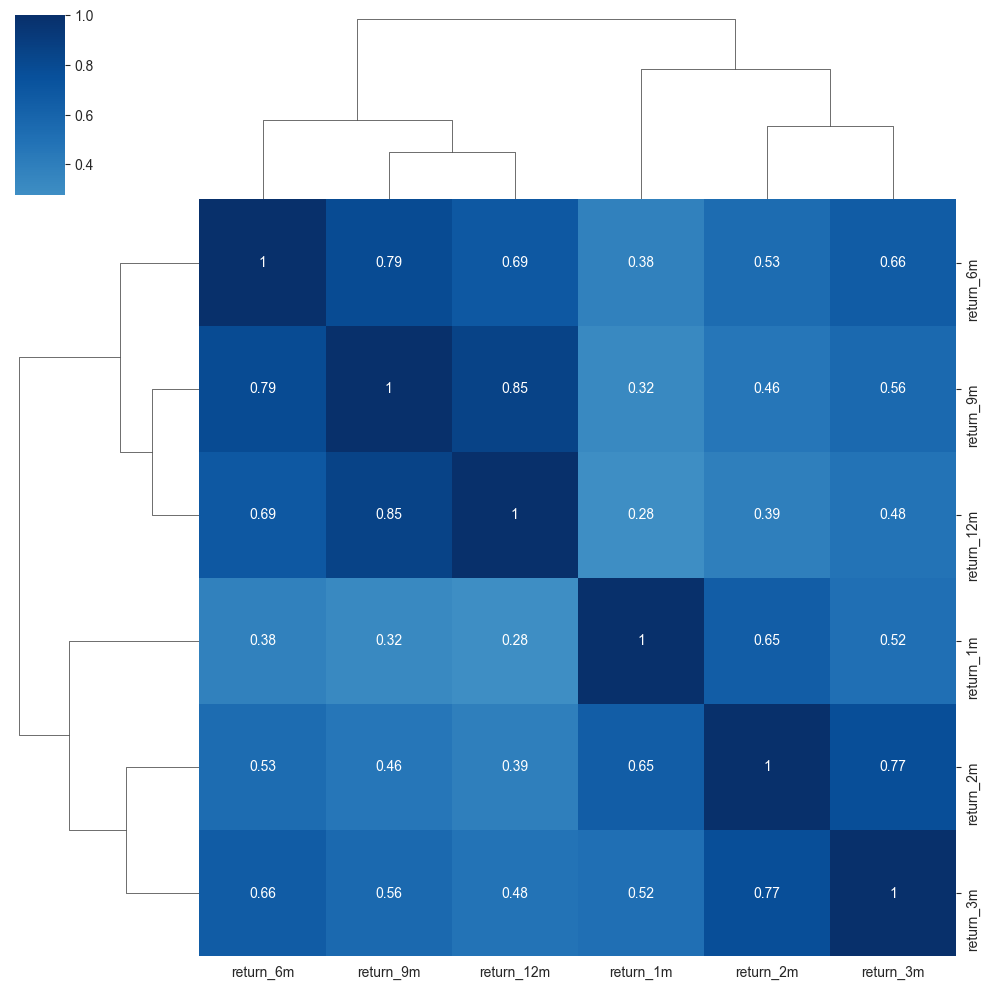

In [37]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [38]:
data.index.get_level_values('ticker').nunique()

5254

## Rolling Factor Betas

In [39]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()
factor_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 291 entries, 2000-01-31 to 2024-03-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  291 non-null    float64
 1   SMB     291 non-null    float64
 2   HML     291 non-null    float64
 3   RMW     291 non-null    float64
 4   CMA     291 non-null    float64
dtypes: float64(5)
memory usage: 13.6 KB


,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,-0.0474,0.0442,-0.0188,-0.0629,0.0472
2000-02-29,0.0245,0.1828,-0.0959,-0.1865,-0.0048
2000-03-31,0.0520,-0.1532,0.0813,0.1179,-0.0159
2000-04-30,-0.0640,-0.0501,0.0726,0.0766,0.0565
2000-05-31,-0.0442,-0.0381,0.0475,0.0413,0.0137


In [40]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()
factor_data.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 416048 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-03-31 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Mkt-RF     416048 non-null  float64
 1   SMB        416048 non-null  float64
 2   HML        416048 non-null  float64
 3   RMW        416048 non-null  float64
 4   CMA        416048 non-null  float64
 5   return_1m  416048 non-null  float64
dtypes: float64(6)
memory usage: 20.8+ MB


Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2015-01-31 -0.0311 -0.0092 -0.0358  0.0161 -0.0165  -0.075164
       2015-02-28  0.0613  0.0032 -0.0186 -0.0112 -0.0182   0.117578
       2015-03-31 -0.0112  0.0307 -0.0037  0.0009 -0.0052  -0.013250
       2015-04-30  0.0059 -0.0309  0.0182  0.0006 -0.0061  -0.004329
       2015-05-31  0.0136  0.0083 -0.0114 -0.0179 -0.0074  -0.004348

In [41]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# T = 24
# betas = (factor_data.groupby(level='ticker',
#                              group_keys=False)
#          .apply(lambda x: RollingOLS(endog=x.return_1m,
#                                      exog=sm.add_constant(x.drop('return_1m', axis=1)),
#                                      window=min(T, x.shape[0]-1))
#                 .fit(params_only=True)
#                 .params
#                 .drop('const', axis=1)))

T = 24

def compute_rolling_ols(group):
    n_obs = group.shape[0]
    n_regressors = group.shape[1]  # Including the intercept term
    window_size = min(T, n_obs - 1)
    
    if n_obs > n_regressors and window_size > n_regressors:
        return (RollingOLS(endog=group.return_1m,
                           exog=sm.add_constant(group.drop('return_1m', axis=1)),
                           window=window_size)
                .fit(params_only=True)
                .params
                .drop('const', axis=1))
    else:
        return pd.DataFrame()

betas = (factor_data.groupby(level='ticker', group_keys=False)
         .apply(compute_rolling_ols))

In [42]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,302502.000000,302502.000000,302502.000000,302502.000000,302502.000000,415675.000000
mean,0.984931,0.672626,0.047159,-0.190403,0.137967,1.202424
std,0.870991,1.403991,1.259592,2.018970,1.953724,2.739278
min,-15.275598,-15.440554,-21.973236,-40.703929,-35.368657,-57.358439
25%,0.502289,-0.120157,-0.563679,-1.044368,-0.874774,0.000000
50%,0.938291,0.564107,0.120181,-0.035689,0.028750,0.562694
75%,1.412266,1.356839,0.763530,0.753273,1.006663,2.440155
max,13.856299,12.749752,21.315993,33.296048,64.859718,56.299793


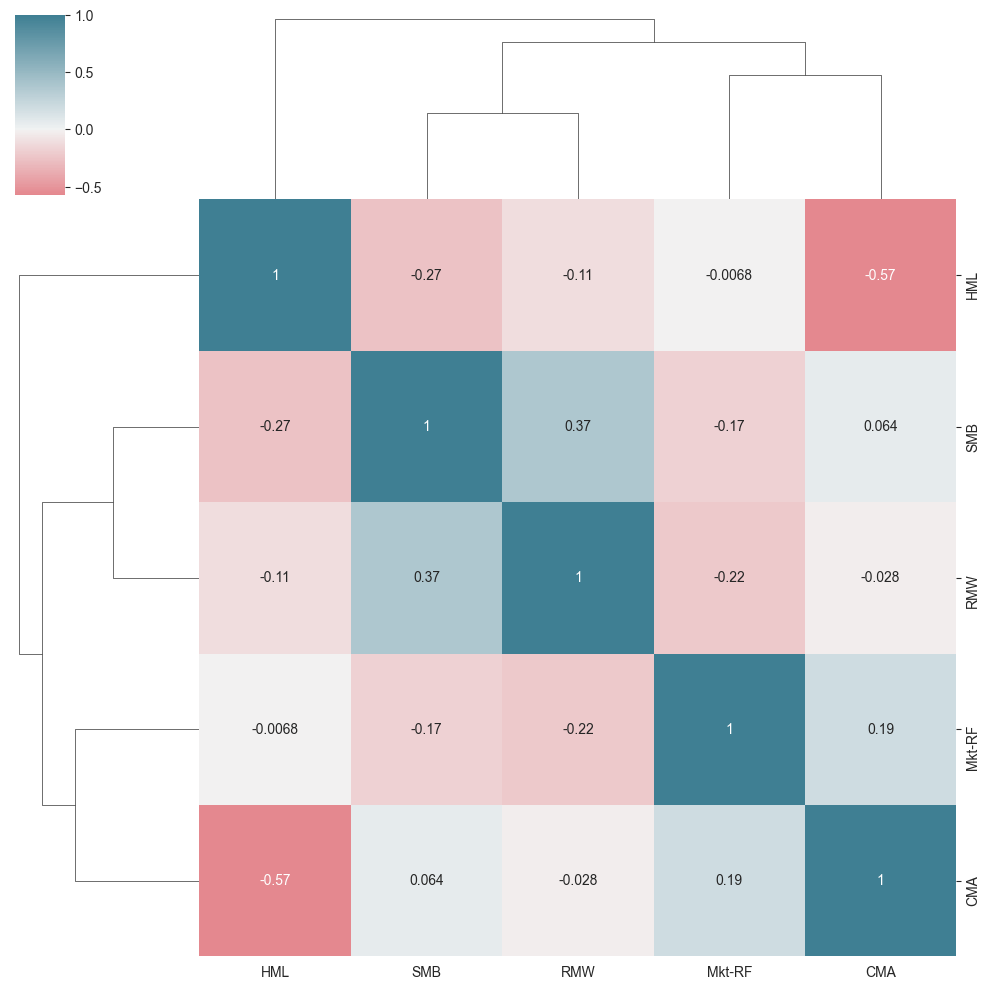

In [43]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [44]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 426556 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-05-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   426556 non-null  float64
 1   return_2m   426556 non-null  float64
 2   return_3m   426556 non-null  float64
 3   return_6m   426556 non-null  float64
 4   return_9m   426556 non-null  float64
 5   return_12m  426556 non-null  float64
 6   Mkt-RF      297371 non-null  float64
 7   SMB         297371 non-null  float64
 8   HML         297371 non-null  float64
 9   RMW         297371 non-null  float64
 10  CMA         297371 non-null  float64
dtypes: float64(11)
memory usage: 53.3+ MB


### Impute mean for missing factor betas

In [45]:
# data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
# data.info()

# Define the list of factors
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Fill missing values with the mean within each group
data[factors] = data.groupby('ticker')[factors].transform(lambda x: x.fillna(x.mean()))

# Display the DataFrame info
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 426556 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-05-31 00:00:00'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   426556 non-null  float64
 1   return_2m   426556 non-null  float64
 2   return_3m   426556 non-null  float64
 3   return_6m   426556 non-null  float64
 4   return_9m   426556 non-null  float64
 5   return_12m  426556 non-null  float64
 6   Mkt-RF      425937 non-null  float64
 7   SMB         425937 non-null  float64
 8   HML         425937 non-null  float64
 9   RMW         425937 non-null  float64
 10  CMA         425937 non-null  float64
dtypes: float64(11)
memory usage: 53.3+ MB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [46]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [47]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

In [48]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 426556 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-05-31 00:00:00'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      426556 non-null  float64
 1   return_2m      426556 non-null  float64
 2   return_3m      426556 non-null  float64
 3   return_6m      426556 non-null  float64
 4   return_9m      426556 non-null  float64
 5   return_12m     426556 non-null  float64
 6   Mkt-RF         425937 non-null  float64
 7   SMB            425937 non-null  float64
 8   HML            425937 non-null  float64
 9   RMW            425937 non-null  float64
 10  CMA            425937 non-null  float64
 11  momentum_2     426556 non-null  float64
 12  momentum_3     426556 non-null  float64
 13  momentum_6     426556 non-null  float64
 14  momentum_9     426556 non-null  float64
 15  momentum_12    426556 non-null  float64
 16  

## Target: Holding Period Returns

In [49]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [50]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3
ticker date                                                                                                                     
A      2015-04-30  -0.004348  -0.033105  -0.002567  -0.004329  -0.008800   0.031653      -0.013250       0.117578      -0.075164
       2015-05-31  -0.061032  -0.001675  -0.040370  -0.004348  -0.004339  -0.007318      -0.004329      -0.013250       0.117578
       2015-06-30   0.061435  -0.029868  -0.037229  -0.061032  -0.033105  -0.023607      -0.004348      -0.004329      -0.013250
       2015-07-31  -0.113318  -0.083066  -0.025730   0.061435  -0.001675  -0.002567      -0.061032      -0.004348      -0.004329
       2015-08-31  -0.051783   0.021257   0.049240  -0.113318  -0.029868  -0.040370       0.061435      -0.061032      -0.004348
       2015-09-30   0.099922   0.103718   0.068895  -0.051783  -0.083066  -0.037229      -0.113318       0.061435      -0.061032
       2015-10-31   0.107527   0.053711  -0.000057   0.099922   0.021257  -0.025730      -0.051783      -0.113318       0.061435
       2015-11-30   0.002510  -0.049864  -0.036101   0.107527   0.103718   0.049240       0.099922      -0.051783      -0.113318
       2015-12-31  -0.099502  -0.054845  -0.015881   0.002510   0.053711   0.068895       0.107527       0.099922      -0.051783
       2016-01-31  -0.007974   0.028798   0.029127  -0.099502  -0.049864  -0.000057       0.002510       0.107527       0.099922

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 426556 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-05-31 00:00:00'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      426556 non-null  float64
 1   return_2m      426556 non-null  float64
 2   return_3m      426556 non-null  float64
 3   return_6m      426556 non-null  float64
 4   return_9m      426556 non-null  float64
 5   return_12m     426556 non-null  float64
 6   Mkt-RF         425937 non-null  float64
 7   SMB            425937 non-null  float64
 8   HML            425937 non-null  float64
 9   RMW            425937 non-null  float64
 10  CMA            425937 non-null  float64
 11  momentum_2     426556 non-null  float64
 12  momentum_3     426556 non-null  float64
 13  momentum_6     426556 non-null  float64
 14  momentum_9     426556 non-null  float64
 15  momentum_12    426556 non-null  float64
 16  

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [52]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

In [53]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5494 entries, A to ZYXI
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5494 non-null   float64
 1   ipoyear    5494 non-null   float64
 2   sector     5490 non-null   object 
dtypes: float64(2), object(1)
memory usage: 300.7+ KB


In [54]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 113 entries, 2024-05-31 to 2015-01-31
Columns: 5254 entries, A to ZYXI
dtypes: float64(5254)
memory usage: 4.5 MB


In [55]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

In [56]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [57]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

## Store data

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 426556 entries, ('A', Timestamp('2015-01-31 00:00:00')) to ('ZYXI', Timestamp('2024-05-31 00:00:00'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      426556 non-null  float64
 1   return_2m      426556 non-null  float64
 2   return_3m      426556 non-null  float64
 3   return_6m      426556 non-null  float64
 4   return_9m      426556 non-null  float64
 5   return_12m     426556 non-null  float64
 6   Mkt-RF         425937 non-null  float64
 7   SMB            425937 non-null  float64
 8   HML            425937 non-null  float64
 9   RMW            425937 non-null  float64
 10  CMA            425937 non-null  float64
 11  momentum_2     426556 non-null  float64
 12  momentum_3     426556 non-null  float64
 13  momentum_6     426556 non-null  float64
 14  momentum_9     426556 non-null  float64
 15  momentum_12    426556 non-null  float64
 16  

In [59]:
import pandas as pd
from datetime import datetime
import numpy as np

# Ensure the necessary functions are imported and used correctly
idx = pd.IndexSlice

with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2024, 5, 17)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/assets.h5
/engineered_features                               frame        (shape->[421302,33])                                                                    
/sharadar/sep/prices                               frame        (shape->[17246022,12])                                                                  
/sharadar/sep/stocks                               frame        (shape->[5494,6])                                                                       
/stooq/5/us/nasdaq/etfs/prices                     frame_table  (typ->appendable_multi,nrows->457963,ncols->9,indexers->[index],dc->[date_time,ticker]) 
/stooq/5/us/nasdaq/etfs/tickers                    frame_table  (typ->appendable,nrows->357,ncols->2,indexers->[index],dc->[])                          
/stooq/5/us/nasdaq/stocks/prices                   frame_table  (typ->appendable_multi,nrows->6317799,ncols->9,indexers->[index],dc->[date_time,ticker])
/stooq/5/us/nasdaq